In [1]:
import torch
from hydra import compose, initialize

import wandb
from src.eval.visualize import visualize_dvinp_both
from src.utils.load_dvinp import load_dvinp

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [3]:
project = "cluster-noscore-fix"
run = "mean-free-True-1-None-None-False-16-1-1-2-2-64-6-GELU" # "bca-free-True-None-None-None-False-16-1-1-2-2-64-6-GELU"

dir = f"../models/{project}/{run}"

api = wandb.Api()

for s in ["dvinp.pth:v0", "optim.pth:v0", "cfg.yaml:v0"]:
    artifact = api.artifact(f"{project}/{run}_{s}")
    artifact.download(root=f"../models/{project}/{run}")

# dir = f"../models/dis"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    dvinp, trainer, test_loader = load_dvinp(
        cfg=cfg, 
        device=device, 
        dir=dir, 
        load_decoder_only=False, 
        train_decoder=True
    ) 


Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 270796.46it/s]
Dropped Escape call with ulEscapeCode : 0x03007703


loaded dvinp from ../models/cluster-noscore-fix/mean-free-True-1-None-None-False-16-1-1-2-2-64-6-GELU/dvinp.pth
loaded optim from ../models/cluster-noscore-fix/mean-free-True-1-None-None-False-16-1-1-2-2-64-6-GELU/optim.pth


In [5]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="test", name="".join([f"({k}:{v})" for k, v in cfg.model.items()]))

In [6]:
train = False

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 50
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=cfg.training.alpha,
        validate=True
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

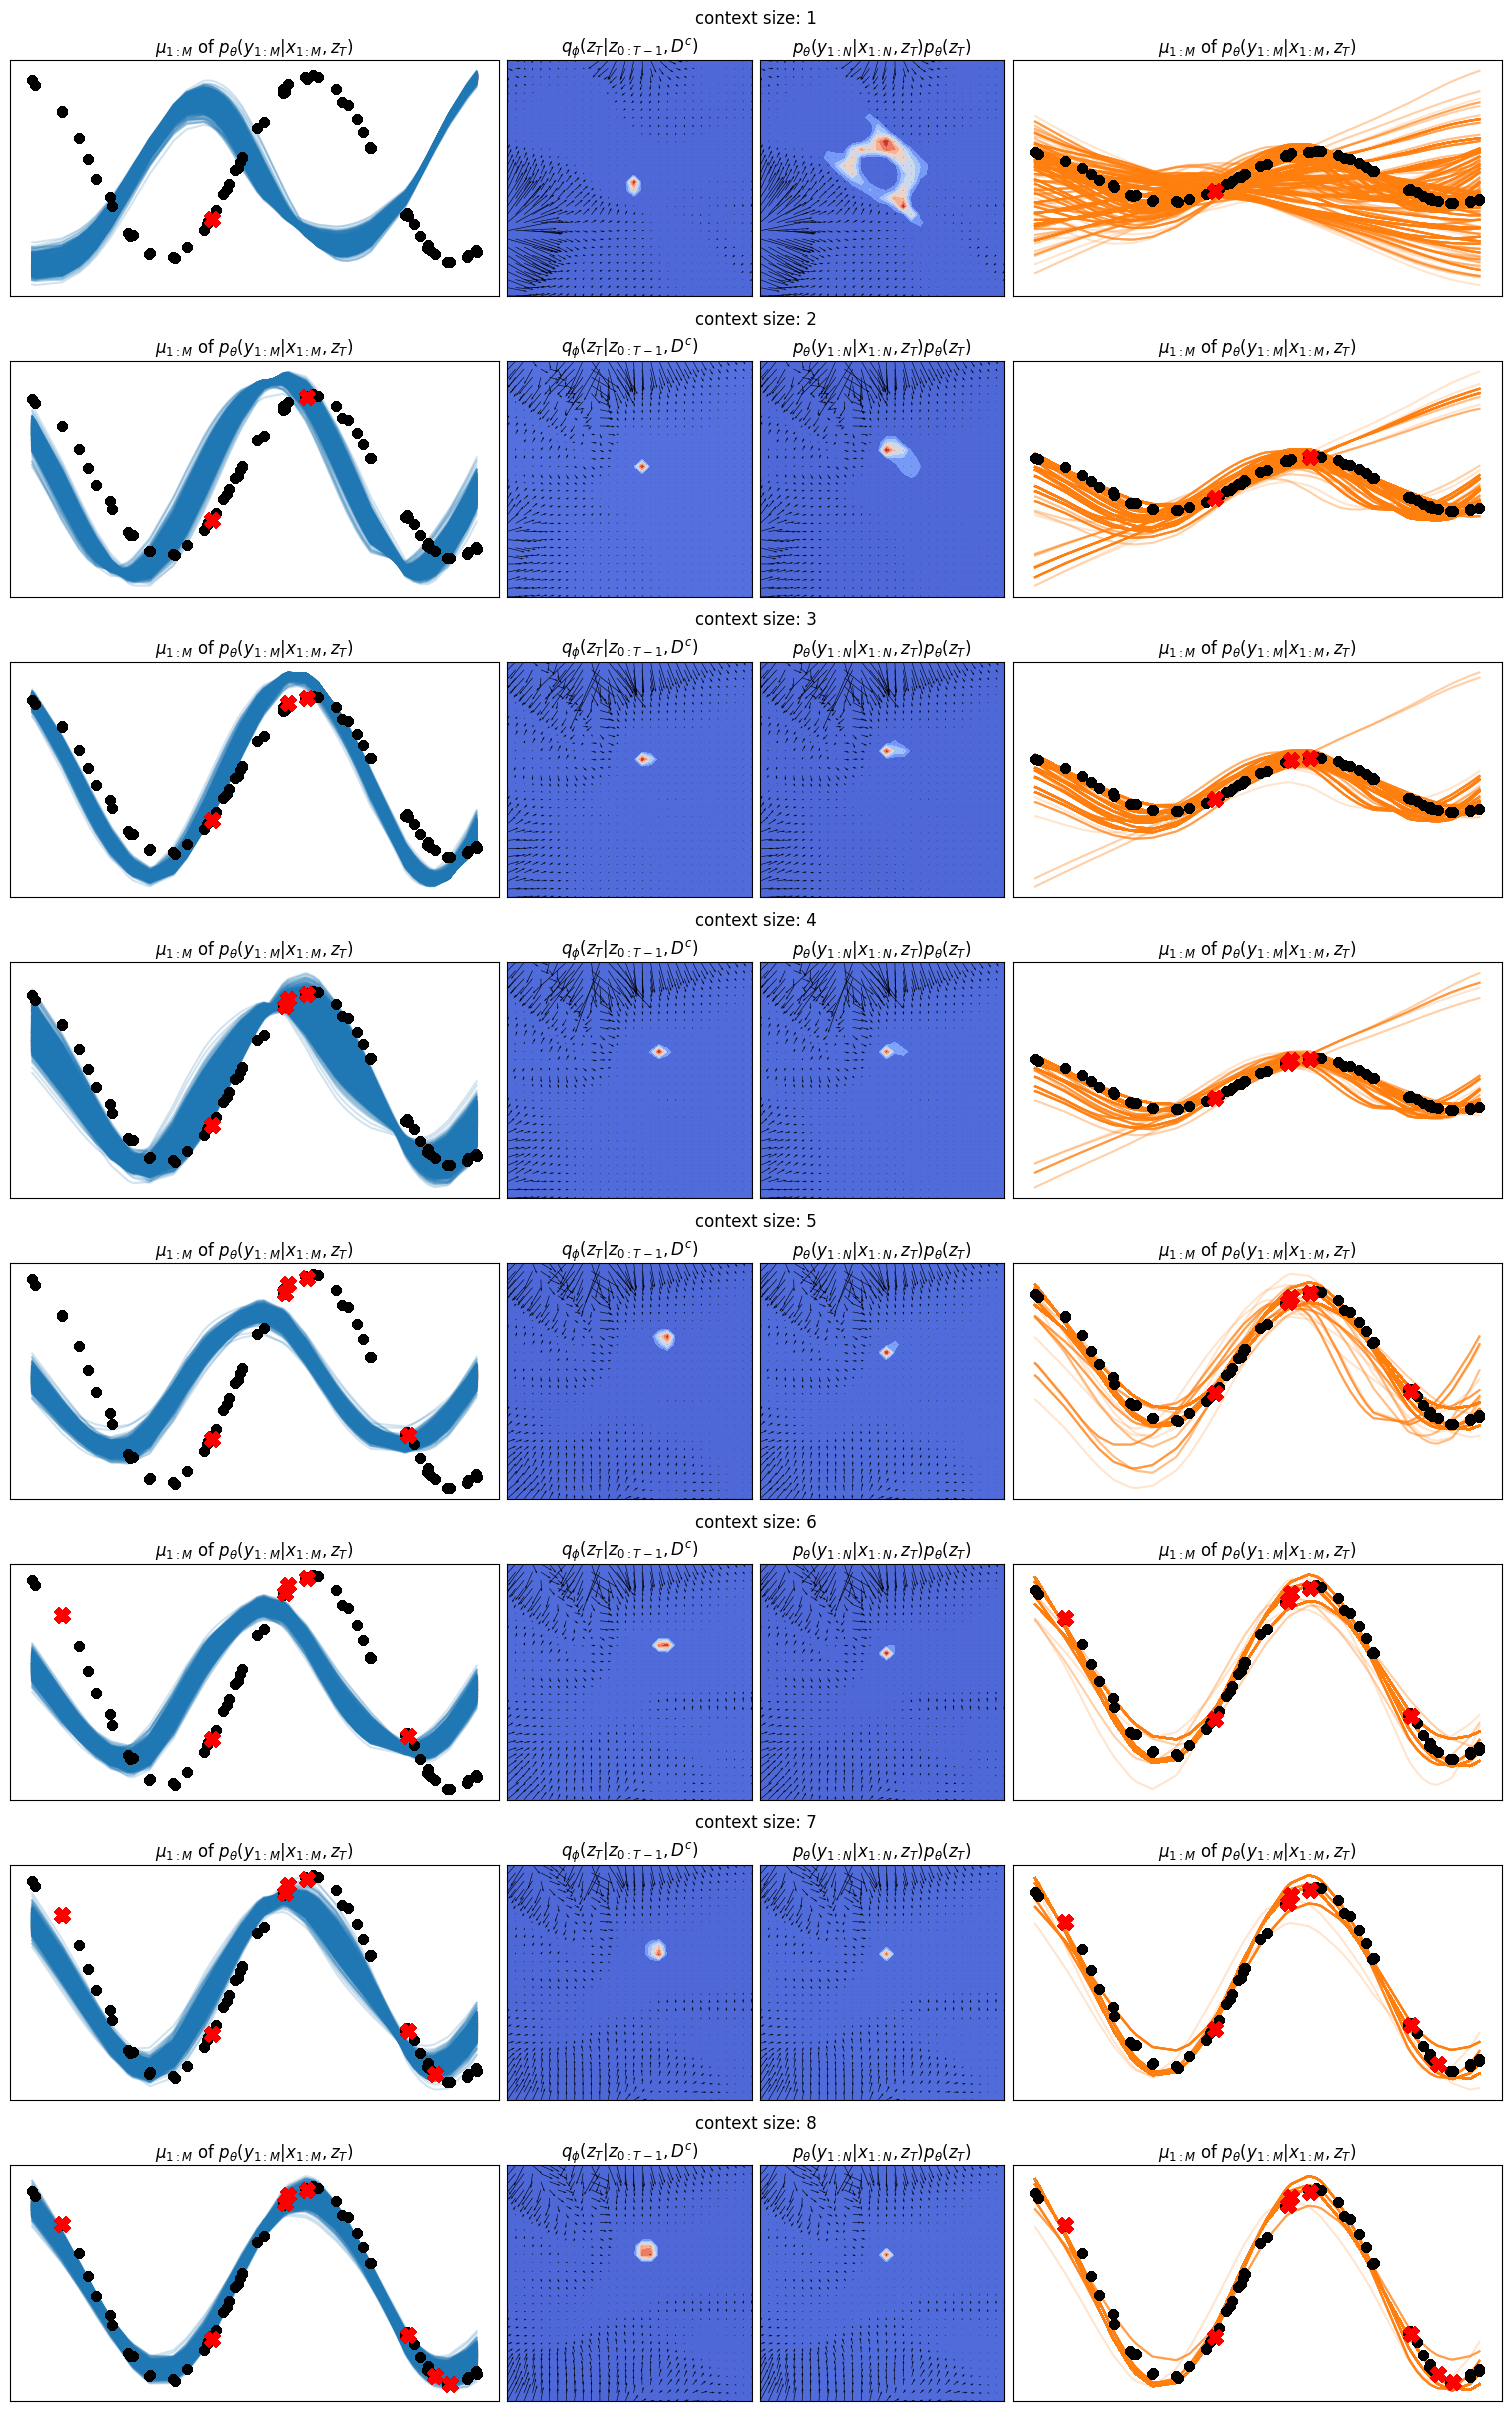

In [9]:
max_context_size = 8
num_samples = 900 # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=dvinp,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)